<a href="https://www.bigdatauniversity.com"><img src="https://ibm.box.com/shared/static/cw2c7r3o20w9zn8gkecaeyjhgw3xdgbj.png" width="400" align="center"></a>

<h1 align="center"><font size="5">Classification with Python</font></h1>

In this notebook we try to practice all the classification algorithms that we learned in this course.

We load a dataset using Pandas library, and apply the following algorithms, and find the best one for this specific dataset by accuracy evaluation methods.

Lets first load required libraries:

In [348]:
import itertools
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter
import pandas as pd
import numpy as np
import matplotlib.ticker as ticker
from sklearn import preprocessing
%matplotlib inline

### About dataset

This dataset is about past loans. The __Loan_train.csv__ data set includes details of 346 customers whose loan are already paid off or defaulted. It includes following fields:

| Field          | Description                                                                           |
|----------------|---------------------------------------------------------------------------------------|
| Loan_status    | Whether a loan is paid off on in collection                                           |
| Principal      | Basic principal loan amount at the                                                    |
| Terms          | Origination terms which can be weekly (7 days), biweekly, and monthly payoff schedule |
| Effective_date | When the loan got originated and took effects                                         |
| Due_date       | Since it’s one-time payoff schedule, each loan has one single due date                |
| Age            | Age of applicant                                                                      |
| Education      | Education of applicant                                                                |
| Gender         | The gender of applicant                                                               |

### Load Data From CSV File  

In [349]:
df = pd.read_csv('https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_train.csv')

### Test set

In [350]:
from sklearn.metrics import jaccard_similarity_score
from sklearn.metrics import f1_score
from sklearn.metrics import log_loss

test_df=pd.read_csv('https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_test.csv')

### Convert to date time object 

In [351]:
df['due_date'] = pd.to_datetime(df['due_date'])
df['effective_date'] = pd.to_datetime(df['effective_date'])
df.head()
test_df['due_date'] = pd.to_datetime(test_df['due_date'])
test_df['effective_date'] = pd.to_datetime(test_df['effective_date'])

# Data visualization and pre-processing



Let’s see how many of each class is in our data set 

In [352]:
df['loan_status'].value_counts()

PAIDOFF       260
COLLECTION     86
Name: loan_status, dtype: int64

260 people have paid off the loan on time while 86 have gone into collection 


Lets plot some columns to underestand data better:

In [353]:
# notice: installing seaborn might takes a few minutes
# !conda install -c anaconda seaborn -y

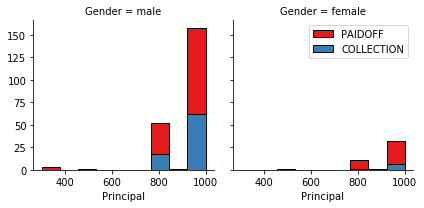

In [354]:
import seaborn as sns

bins = np.linspace(df.Principal.min(), df.Principal.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'Principal', bins=bins, ec="k")

g.axes[-1].legend()
plt.show()

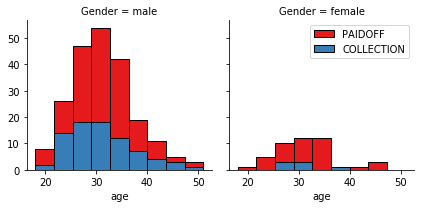

In [355]:
bins = np.linspace(df.age.min(), df.age.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'age', bins=bins, ec="k")

g.axes[-1].legend()
plt.show()

# Pre-processing:  Feature selection/extraction

### Lets look at the day of the week people get the loan 

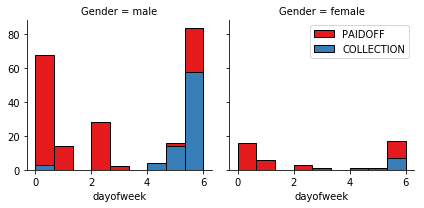

In [356]:
df['dayofweek'] = df['effective_date'].dt.dayofweek
bins = np.linspace(df.dayofweek.min(), df.dayofweek.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'dayofweek', bins=bins, ec="k")
g.axes[-1].legend()
plt.show()

test_df['dayofweek'] = test_df['effective_date'].dt.dayofweek

We see that people who get the loan at the end of the week dont pay it off, so lets use Feature binarization to set a threshold values less then day 4 

In [357]:
df['weekend'] = df['dayofweek'].apply(lambda x: 1 if (x>3)  else 0)
df.head()
test_df['weekend'] = test_df['dayofweek'].apply(lambda x: 1 if (x>3)  else 0)

## Convert Categorical features to numerical values

Lets look at gender:

In [358]:
df.groupby(['Gender'])['loan_status'].value_counts(normalize=True)
test_df.groupby(['Gender'])['loan_status'].value_counts(normalize=True)

Gender  loan_status
female  PAIDOFF        0.727273
        COLLECTION     0.272727
male    PAIDOFF        0.744186
        COLLECTION     0.255814
Name: loan_status, dtype: float64

86 % of female pay there loans while only 73 % of males pay there loan


Lets convert male to 0 and female to 1:


In [359]:
df['Gender'].replace(to_replace=['male','female'], value=[0,1],inplace=True)
df.head()
test_df['Gender'].replace(to_replace=['male','female'], value=[0,1],inplace=True)

## One Hot Encoding  
#### How about education?

In [360]:
df.groupby(['education'])['loan_status'].value_counts(normalize=True)
test_df.groupby(['education'])['loan_status'].value_counts(normalize=True)

education             loan_status
Bechalor              PAIDOFF        1.000000
High School or Below  PAIDOFF        0.523810
                      COLLECTION     0.476190
Master or Above       PAIDOFF        1.000000
college               PAIDOFF        0.826087
                      COLLECTION     0.173913
Name: loan_status, dtype: float64

#### Feature befor One Hot Encoding

In [361]:
df[['Principal','terms','age','Gender','education']].head()
test_df[['Principal','terms','age','Gender','education']].head()

,Principal,terms,age,Gender,education
0,1000,30,50,1,Bechalor
1,300,7,35,0,Master or Above
2,1000,30,43,1,High School or Below
3,1000,30,26,0,college
4,800,15,29,0,Bechalor


#### Use one hot encoding technique to conver categorical varables to binary variables and append them to the feature Data Frame 

In [362]:
Feature = df[['Principal','terms','age','Gender','weekend']]
Feature = pd.concat([Feature,pd.get_dummies(df['education'])], axis=1)
Feature.drop(['Master or Above'], axis = 1,inplace=True)
Feature.head()

Feature_Test = test_df[['Principal','terms','age','Gender','weekend']]
Feature_Test = pd.concat([Feature_Test,pd.get_dummies(test_df['education'])], axis=1)
Feature_Test.drop(['Master or Above'], axis = 1,inplace=True)

### Feature selection

Lets defind feature sets, X:

In [363]:
X = Feature
X_Test=Feature_Test

What are our labels?

In [364]:
y = df['loan_status'].values
y_Test = test_df['loan_status'].values
y[0:5]

array(['PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF'],
      dtype=object)

## Normalize Data 

Data Standardization give data zero mean and unit variance (technically should be done after train test split )

In [365]:
X = preprocessing.StandardScaler().fit(X).transform(X)
X_Test = preprocessing.StandardScaler().fit(X_Test).transform(X_Test)
X[0:5]

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.
  """Entry point for launching an IPython kernel.
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.
  


array([[ 0.52,  0.92,  2.33, -0.42, -1.21, -0.38,  1.14, -0.87],
       [ 0.52,  0.92,  0.34,  2.38, -1.21,  2.62, -0.88, -0.87],
       [ 0.52, -0.96, -0.65, -0.42, -1.21, -0.38, -0.88,  1.15],
       [ 0.52,  0.92, -0.49,  2.38,  0.83, -0.38, -0.88,  1.15],
       [ 0.52,  0.92, -0.32, -0.42,  0.83, -0.38, -0.88,  1.15]])

# Classification 

Now, it is your turn, use the training set to build an accurate model. Then use the test set to report the accuracy of the model
You should use the following algorithm:
- K Nearest Neighbor(KNN)
- Decision Tree
- Support Vector Machine
- Logistic Regression



__ Notice:__ 
- You can go above and change the pre-processing, feature selection, feature-extraction, and so on, to make a better model.
- You should use either scikit-learn, Scipy or Numpy libraries for developing the classification algorithms.
- You should include the code of the algorithm in the following cells.

# K Nearest Neighbor(KNN)
Notice: You should find the best k to build the model with the best accuracy.  
**warning:** You should not use the __loan_test.csv__ for finding the best k, however, you can split your train_loan.csv into train and test to find the best __k__.

In [366]:
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
   
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=4)
knn_acc=[]
K=16
for k in range(1,K+1):
    n=KNeighborsClassifier(n_neighbors=k).fit(X_train,y_train)
    yhat=n.predict(X_test)
    knn_acc.append(metrics.accuracy_score(y_test,yhat))
mean=sum(knn_acc)/len(knn_acc)

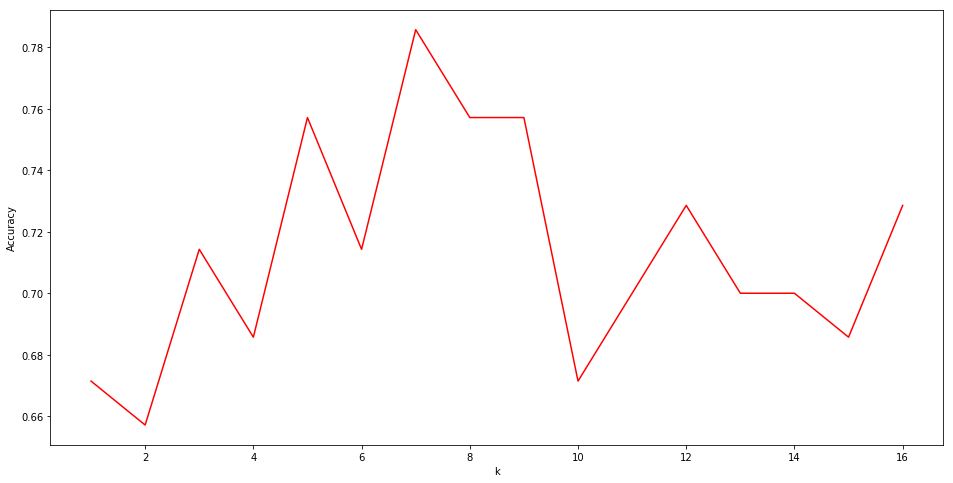

In [367]:
plt.figure(figsize=(16,8))
plt.plot(range(1,K+1),knn_acc,'r')
plt.ylabel('Accuracy')
plt.xlabel('k')
plt.show()

In [368]:
print('The maximum accuracy is',round(max(knn_acc),3),'with k=',acc.index(max(knn_acc))+1)

The maximum accuracy is 0.786 with k= 7


In [369]:
max_K=knn_acc.index(max(knn_acc))+1
n=KNeighborsClassifier(n_neighbors=max_K).fit(X_Test,y_Test)
yhat=n.predict(X_Test)
knn_jaccard=round(jaccard_similarity_score(y_Test,yhat),3)
knn_f1_score=round(f1_score(y_Test,yhat,average='weighted'),3)
knn_f1_score,knn_jaccard

(0.869, 0.87)

# Decision Tree

In [370]:
from sklearn.tree import DecisionTreeClassifier

d=16
dt_acc=[]
for i in range(3,d+1):    
    tree=DecisionTreeClassifier(criterion="entropy",max_depth=i)
    tree.fit(X_train,y_train)
    yhat=tree.predict(X_test)
    dt_acc.append(metrics.accuracy_score(y_test,yhat))

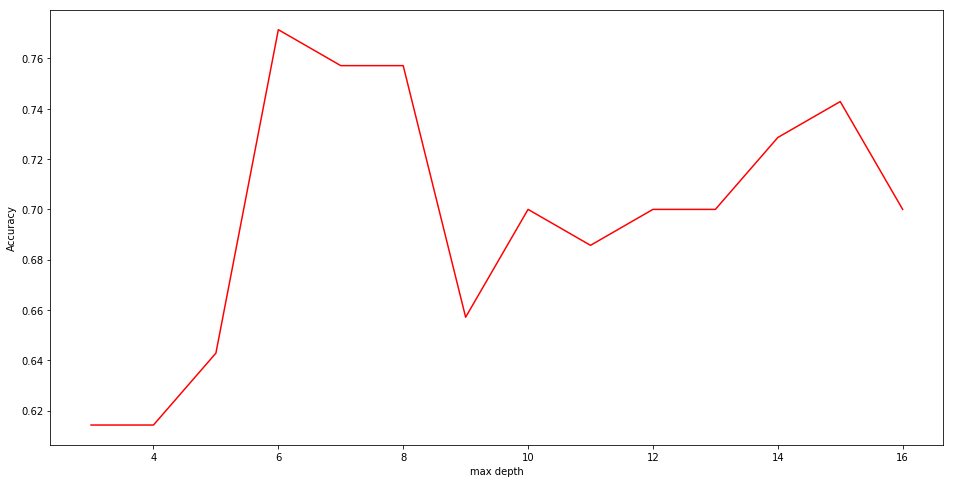

In [371]:
plt.figure(figsize=(16,8))
plt.plot(range(3,d+1),dt_acc,'r')
plt.ylabel('Accuracy')
plt.xlabel('max depth')
plt.show()

In [372]:
print('The maximum accuracy is',round(max(dt_acc),3),'with max depth=',dt_acc.index(max(dt_acc))+3)

The maximum accuracy is 0.771 with max depth= 6


In [373]:
max_depth=dt_acc.index(max(dt_acc))+3
tree=DecisionTreeClassifier(criterion="entropy",max_depth=max_depth).fit(X_train,y_train)
yhat=tree.predict(X_Test)
dt_jaccard=round(jaccard_similarity_score(y_Test,yhat),3)
dt_f1_score=round(f1_score(y_Test,yhat,average='weighted'),3)
dt_jaccard,dt_f1_score

(0.722, 0.67)

# Support Vector Machine

In [374]:
from sklearn import svm
SVM=svm.SVC(kernel='rbf',gamma='auto')
SVM.fit(X_train, y_train)
yhat=SVM.predict(X_test)

In [375]:
from sklearn.metrics import classification_report, confusion_matrix

# modified function from LAB-ML0101EN-Clas-SVM-cancer
def plot_confusion_matrix(yhat,y_test, classes,
                          title='Confusion matrix'):
    
    cm=confusion_matrix(y_test, yhat, labels=['PAIDOFF','COLLECTION'])
    cmap=plt.cm.Reds
    print('Confusion matrix, kernel=',k)
    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt='d'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
    print (classification_report(y_test, yhat))
    plt.figure()

Confusion matrix, kernel= rbf
[[48  7]
 [11  4]]
              precision    recall  f1-score   support

  COLLECTION       0.36      0.27      0.31        15
     PAIDOFF       0.81      0.87      0.84        55

   micro avg       0.74      0.74      0.74        70
   macro avg       0.59      0.57      0.57        70
weighted avg       0.72      0.74      0.73        70

Confusion matrix, kernel= poly
[[53  2]
 [14  1]]
              precision    recall  f1-score   support

  COLLECTION       0.33      0.07      0.11        15
     PAIDOFF       0.79      0.96      0.87        55

   micro avg       0.77      0.77      0.77        70
   macro avg       0.56      0.52      0.49        70
weighted avg       0.69      0.77      0.71        70

Confusion matrix, kernel= rbf
[[48  7]
 [11  4]]
              precision    recall  f1-score   support

  COLLECTION       0.36      0.27      0.31        15
     PAIDOFF       0.81      0.87      0.84        55

   micro avg       0.74      0.74 

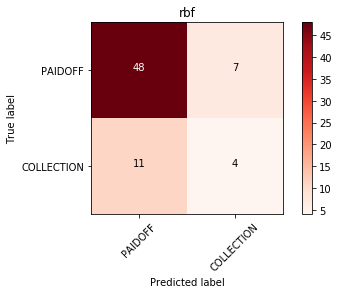

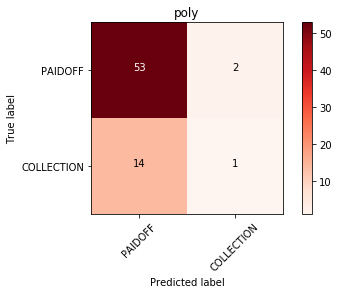

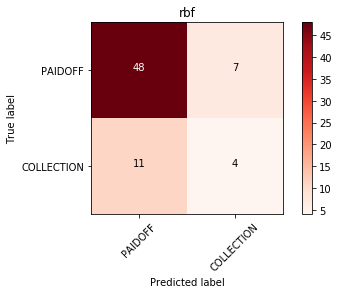

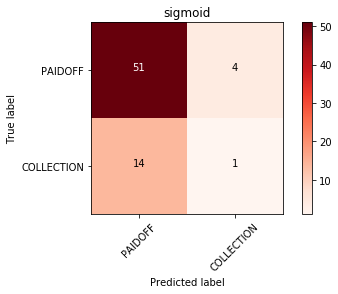

<Figure size 432x288 with 0 Axes>

In [376]:
kernels=['rbf','poly','rbf','sigmoid']
svm_j=[]
svm_f1=[]
svm_acc=[]
for k in kernels:
    SVM=svm.SVC(kernel=k,gamma='auto')
    SVM.fit(X_train, y_train)
    yhat=SVM.predict(X_test)
    plot_confusion_matrix(yhat,y_test,classes=['PAIDOFF','COLLECTION'], title=k)
    svm_j.append(jaccard_similarity_score(y_test,yhat))
    svm_f1.append(f1_score(y_test,yhat,average='weighted'))
    svm_acc.append(0.5*f1_score(y_test,yhat,average='weighted')+0.5*jaccard_similarity_score(y_test,yhat))

In [377]:
max_f1=svm_f1.index(max(svm_f1))+1
max_jaccard=svm_j.index(max(svm_j))+1
print('The maximum Jaccard score is',round(svm_j[max_jaccard],3),'with kernel=',kernels[max_jaccard+1])
print('The maximum F1 score is',round(svm_f1[max_f1],3),'with kernel=',kernels[max_f1+1])

The maximum Jaccard score is 0.743 with kernel= sigmoid
The maximum F1 score is 0.706 with kernel= rbf


In [378]:
SVM=svm.SVC(kernel='rbf',gamma='auto')
SVM.fit(X_train, y_train)
yhat=SVM.predict(X_Test)
svm_jaccard=round(jaccard_similarity_score(y_Test,yhat),3)
svm_f1_score=round(f1_score(y_Test,yhat,average='weighted'),3)
svm_jaccard,svm_f1_score

(0.796, 0.758)

# Logistic Regression

In [379]:
from sklearn.linear_model import LogisticRegression

log=LogisticRegression(C=0.01,solver='liblinear').fit(X_train,y_train)
yhat=log.predict(X_test)
yhat_prob=log.predict_proba(X_test)

In [380]:
log_jaccard=round(jaccard_similarity_score(y_test, yhat),3)
log_f1=round(f1_score(y_test,yhat,average='weighted'),3)
log_jaccard,log_f1

(0.686, 0.667)

Confusion matrix, kernel= sigmoid
[[48  7]
 [13  2]]
              precision    recall  f1-score   support

  COLLECTION       0.22      0.13      0.17        15
     PAIDOFF       0.79      0.87      0.83        55

   micro avg       0.71      0.71      0.71        70
   macro avg       0.50      0.50      0.50        70
weighted avg       0.67      0.71      0.69        70

Confusion matrix, kernel= sigmoid
[[49  6]
 [13  2]]
              precision    recall  f1-score   support

  COLLECTION       0.25      0.13      0.17        15
     PAIDOFF       0.79      0.89      0.84        55

   micro avg       0.73      0.73      0.73        70
   macro avg       0.52      0.51      0.51        70
weighted avg       0.67      0.73      0.70        70

Confusion matrix, kernel= sigmoid
[[49  6]
 [13  2]]
              precision    recall  f1-score   support

  COLLECTION       0.25      0.13      0.17        15
     PAIDOFF       0.79      0.89      0.84        55

   micro avg       0.73

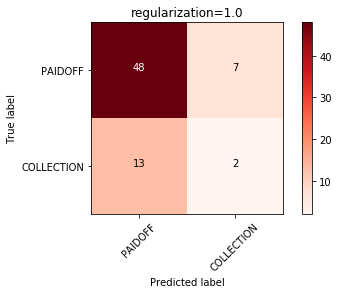

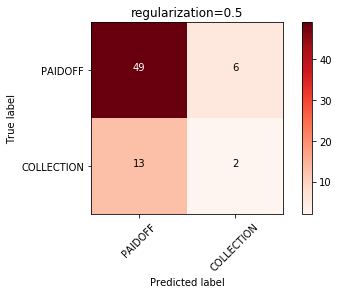

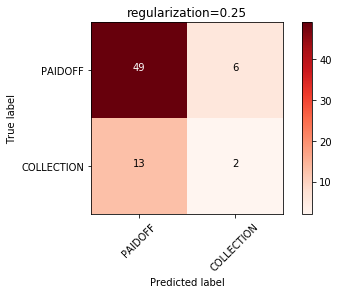

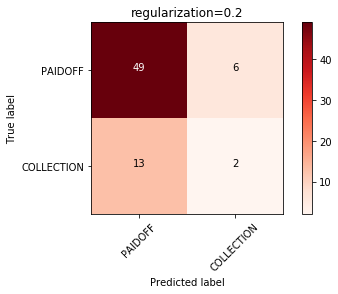

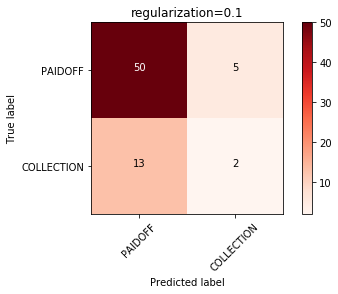

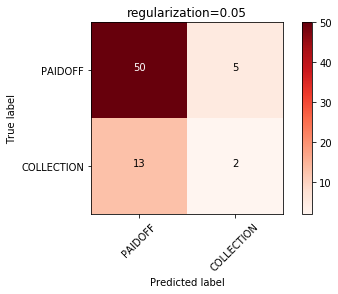

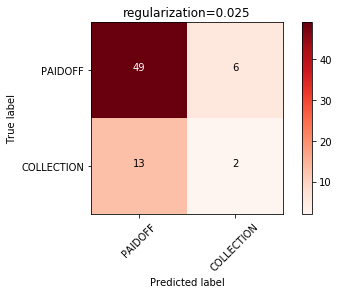

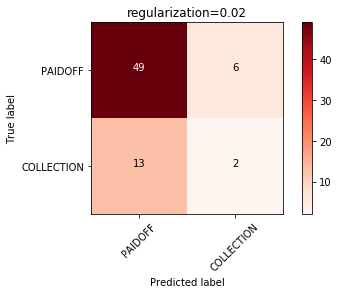

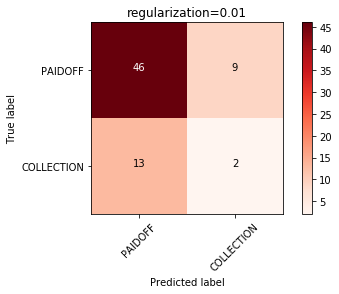

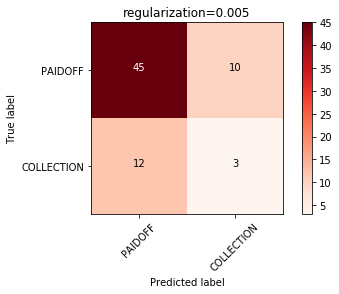

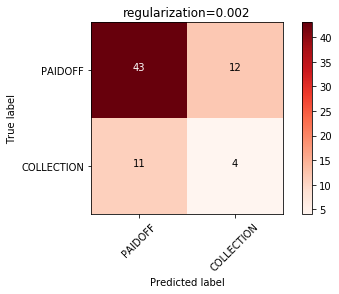

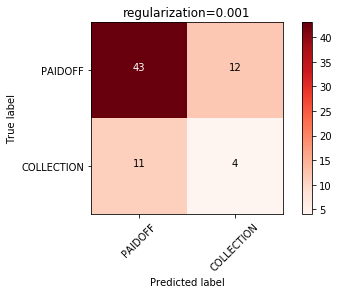

<Figure size 432x288 with 0 Axes>

In [381]:
reg_values=[1,2,4,5,10,20,40,50,100,200,500,1000]
log_j=[]
log_f1=[]
log_acc=[]
for r in reg_values:
    log=LogisticRegression(C=1/r,solver='liblinear').fit(X_train,y_train)
    yhat=log.predict(X_test)
    plot_confusion_matrix(yhat,y_test,classes=['PAIDOFF','COLLECTION'], title="regularization="+str(1/r))
    log_j.append(jaccard_similarity_score(y_test,yhat))
    log_f1.append(f1_score(y_test,yhat,average='weighted'))
    log_acc.append(0.5*f1_score(y_test,yhat,average='weighted')+0.5*jaccard_similarity_score(y_test,yhat))

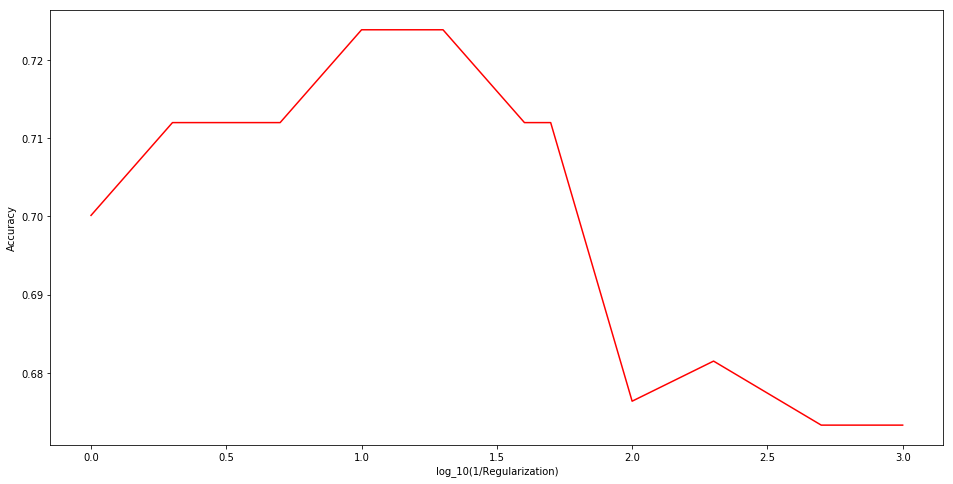

In [382]:
plt.figure(figsize=(16,8))
plt.plot(np.log10(reg_values),log_acc,'r')
plt.ylabel('Accuracy')
plt.xlabel('log_10(1/Regularization)')
plt.show()

In [383]:
best_r=1/reg_values[log_acc.index(max(log_acc))+1]
print('The maximum accuracy is',round(max(log_acc),3),'with regularization=',str(best_r))

The maximum accuracy is 0.724 with regularization= 0.05


In [384]:
from sklearn.metrics import log_loss

log=LogisticRegression(C=best_r,solver='liblinear').fit(X_train,y_train)
yhat=log.predict(X_Test)
yhat_prob=log.predict_proba(X_Test)
log_loss=round(log_loss(y_Test,yhat_prob),3)
log_jaccard=round(jaccard_similarity_score(y_Test,yhat),3)
log_f1_score=round(f1_score(y_Test,yhat,average='weighted'),3)
log_jaccard,log_f1_score,log_loss

(0.759, 0.672, 0.493)

# Report
You should be able to report the accuracy of the built model using different evaluation metrics:

In [385]:
Report = {'Algorithm':  ['KNN', 'Decision Tree','SVM','LogisticRegression'],
          'Jaccard': [knn_jaccard,dt_jaccard,svm_jaccard,log_jaccard],
          'F1-score':  [knn_f1_score,dt_f1_score,svm_f1_score,log_f1_score],
          'LoggLoss': ['NA','NA','NA',log_loss],
         }

report = pd.DataFrame (Report,columns=['Algorithm','Jaccard','F1-score','LoggLoss'])
report.set_index('Algorithm')

,Jaccard,F1-score,LoggLoss
Algorithm,,,
KNN,0.870,0.869,NA
Decision Tree,0.722,0.670,NA
SVM,0.796,0.758,NA
LogisticRegression,0.759,0.672,0.493


<h2>Want to learn more?</h2>

IBM SPSS Modeler is a comprehensive analytics platform that has many machine learning algorithms. It has been designed to bring predictive intelligence to decisions made by individuals, by groups, by systems – by your enterprise as a whole. A free trial is available through this course, available here: <a href="http://cocl.us/ML0101EN-SPSSModeler">SPSS Modeler</a>

Also, you can use Watson Studio to run these notebooks faster with bigger datasets. Watson Studio is IBM's leading cloud solution for data scientists, built by data scientists. With Jupyter notebooks, RStudio, Apache Spark and popular libraries pre-packaged in the cloud, Watson Studio enables data scientists to collaborate on their projects without having to install anything. Join the fast-growing community of Watson Studio users today with a free account at <a href="https://cocl.us/ML0101EN_DSX">Watson Studio</a>

<h3>Thanks for completing this lesson!</h3>

<h4>Author:  <a href="https://ca.linkedin.com/in/saeedaghabozorgi">Saeed Aghabozorgi</a></h4>
<p><a href="https://ca.linkedin.com/in/saeedaghabozorgi">Saeed Aghabozorgi</a>, PhD is a Data Scientist in IBM with a track record of developing enterprise level applications that substantially increases clients’ ability to turn data into actionable knowledge. He is a researcher in data mining field and expert in developing advanced analytic methods like machine learning and statistical modelling on large datasets.</p>

<hr>

<p>Copyright &copy; 2018 <a href="https://cocl.us/DX0108EN_CC">Cognitive Class</a>. This notebook and its source code are released under the terms of the <a href="https://bigdatauniversity.com/mit-license/">MIT License</a>.</p>